In [1]:
import numpy as np
import mnist_data
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import imsave
from scipy.misc import imresize
#import plot_utils
%matplotlib inline

/home/mgyukim/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def gaussian_encoder(x_hat, dim_z, n_hidden, keep_prob):
    with tf.variable_scope("gaussian_MLP_encoder"):
        #Initializer
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)
        
        #1st layer
        encoder_w0 = tf.get_variable('w0', [x_hat.get_shape()[1], n_hidden], initializer=w_init)
        encoder_b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        encoder_h0 = tf.matmul(x_hat, encoder_w0) + encoder_b0
        encoder_h0 = tf.nn.tanh(encoder_h0) #Exponential Linear Units : if h0 < 0, h0_new = h0, else h0_new = exp(h0) - 1
        encoder_h0 = tf.nn.dropout(encoder_h0, keep_prob) # Dropout means that non-participated nodes are randomly determined. The proposition of non-participated nodes is "keep_prob", It means that some of components of h0 have zero value.
    
        # 2nd hidden layer
        encoder_w1 = tf.get_variable('w1', [encoder_h0.get_shape()[1], n_hidden], initializer=w_init)
        encoder_b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        encoder_h1 = tf.matmul(encoder_h0, encoder_w1) + encoder_b1
        encoder_h1 = tf.nn.tanh(encoder_h1)
        encoder_h1 = tf.nn.dropout(encoder_h1, keep_prob)
    
        # Output layer
        # borrowed from https://github.com/altosaar/vae/blob/master/vae.py
        encoder_wo = tf.get_variable('wo', [encoder_h1.get_shape()[1], dim_z * 2], initializer=w_init)
        encoder_bo = tf.get_variable('bo', [dim_z*2], initializer=b_init)
        gaussian_params = tf.matmul(encoder_h1, encoder_wo) + encoder_bo
    
        # The mean parameter is unconstrained
        mean = gaussian_params[:, :dim_z]
    
        # The standard deviaition must be positive. Parametrize with a softplus and add a small epsilon for numerical stability
        # Softplus = log(exp(gaussian_params[:,dim:] + 1))
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, dim_z:])
    
    z = mean + stddev*tf.random_normal(tf.shape(mean), 0, 1, dtype=tf.float32) #By reparametric trick, z = mean + std*N(e|0,1)
    
    return z, mean, stddev
    


In [3]:
def bernoulli_decoder(z, n_hidden, dim_img, keep_prob, reuse=False):
    with tf.variable_scope("bernoulli_MLP_decoder", reuse=reuse): #Reuse flags requires at least declaration of more two variables to be assigned as same tf.variables. If not, "ValueError" occurs. 
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)
    
        # 1st hidden layer
        decoder_w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        decoder_b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        decoder_h0 = tf.matmul(z, decoder_w0) + decoder_b0
        decoder_h0 = tf.nn.tanh(decoder_h0)
        decoder_h0 = tf.nn.dropout(decoder_h0, keep_prob)
    
        # 2nd hidden layer
        decoder_w1 = tf.get_variable('w1', [decoder_h0.get_shape()[1], n_hidden], initializer=w_init)
        decoder_b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        decoder_h1 = tf.matmul(decoder_h0, decoder_w1) + decoder_b1
        decoder_h1 = tf.nn.tanh(decoder_h1)
        decoder_h1 = tf.nn.dropout(decoder_h1, keep_prob)
    
        # Output layer-mean
        decoder_wo = tf.get_variable('wo', [decoder_h1.get_shape()[1], dim_img], initializer=w_init)
        decoder_bo = tf.get_variable('bo', [dim_img], initializer=b_init)
        y = tf.sigmoid(tf.matmul(decoder_h1, decoder_wo) + decoder_bo)
    
        y = tf.clip_by_value(y, 1e-8, 1 - 1e-8) # Function "clip_by_value" is to set all of values in tensor "y" between 1e-8 and 1 - 1e-8.
        
    return y

In [4]:
def autoencoder(x_hat, x, dim_z, n_hidden, dim_img, keep_prob):
    
    #Encoder
    z, mean, stddev = gaussian_encoder(x_hat, dim_z, n_hidden, keep_prob)
    
    #Decoder
    y = bernoulli_decoder(z, n_hidden, dim_img, keep_prob)
    
    # Loss
    marginal_likelihood = tf.reduce_sum(x*tf.log(y) + (1-x)*tf.log(1-y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mean)+tf.square(stddev) - tf.log(1e-8 + tf.square(stddev)) -1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO
    
    return y, z, loss, -marginal_likelihood, KL_divergence

In [5]:
def decoder(z, n_hidden, dim_img):
    y = bernoulli_decoder(z, n_hidden, dim_img, keep_prob=1, reuse=True)
    
    return y

In [6]:
'''
Parameter Setting
'''

IMAGE_SIZE_MNIST = 28

RESULT_DIR = 'results'
ADD_NOISE = False

n_hidden = 300
dim_img = IMAGE_SIZE_MNIST**2
dim_z = 2

In [7]:
'''
Traning
'''
n_epochs = 200
batch_size = 128
learn_rate = 1e-4

In [8]:
'''
Plot
'''

PRR = True
PRR_n_img_x = 10
PRR_n_img_y = 10
PRR_resize_factor = 1.0

PMLR = True
PMLR_n_img_x = 20
PMLR_n_img_y = 20
PMLR_resize_factor = 1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

In [9]:
'''
Prepare MNIST data
'''

train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()
n_sample = train_size
print(test_data.shape)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(10000, 784)


In [10]:
'''
build graph
'''

# Input placeholders
# In denosing-autoencoder, x_hat == x + noise, otherwise x_hat == x

x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

In [11]:
# Optimization
y, z, loss, marginal_likelihood, KL_divergence = autoencoder(x_hat, x, dim_z, n_hidden, dim_img, keep_prob)
latent_variable = decoder(z_in, n_hidden, dim_img)
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

In [12]:
# Plot for reproduce performance

if PRR:
    #PRR = plot_utils.Plot_Reproduce_Performance(RESULT_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)
    n_tot_imgs = PRR_n_img_x*PRR_n_img_y
    
    x_PRR = test_data[0:n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    #PRR.save_images(x_PRR_img, name='input.jpg')
    
    img_PRR = np.zeros((IMAGE_SIZE_MNIST*PRR_n_img_x, IMAGE_SIZE_MNIST*PRR_n_img_y))
    for idx, image in enumerate(x_PRR_img):
        i = int(idx%PRR_n_img_y)
        j = int(idx/PRR_n_img_y)
        
        image_ = imresize(image, size=(IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST), interp = 'bicubic')
        
        if idx == 0:
            print(image_.shape)
            print(image.shape)
        
        img_PRR[j*IMAGE_SIZE_MNIST:j*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST, i*IMAGE_SIZE_MNIST:i*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST] = image
        
    imsave(RESULT_DIR+"/result.jpg", img_PRR)
    

if ADD_NOISE:
    x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
    x_PRR += np.random.randint(2, size=x_PRR.shape)

    x_PRR_img = x_PRR.reshape(n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    #PRR.save_images(x_PRR_img, name='input_noise.jpg')
    img_PRR_Noise = np.zeros((IMAGE_SIZE_MNIST*PRR_n_img_x, IMAGE_SIZE_MNIST*PRR_n_img_y))
    for idx, image in enumerate(x_PRR_img):
        i = int(idx%PRR_n_img_x)
        j = int(idx/PRR_n_img_x)
        
        if idx == 0:
            print(image.shape)
            
        img_PRR_Noise[i*IMAGE_SIZE_MNIST:i*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST, j*IMAGE_SIZE_MNIST:j*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST] = image

    imsave(RESULT_DIR+"/result_noise.jpg", img_PRR_Noise)
    


if PMLR and dim_z == 2:

    #PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULT_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

(28, 28)
(28, 28)


/home/mgyukim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/mgyukim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


epoch 0: L_tot 214.49 L_likelihood 210.15 L_divergence 4.35
214.49228
(28, 28)
(28, 28)


/home/mgyukim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mgyukim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


epoch 1: L_tot 205.40 L_likelihood 200.89 L_divergence 4.50
205.39725
(28, 28)
(28, 28)
epoch 2: L_tot 197.47 L_likelihood 192.61 L_divergence 4.86
197.47
(28, 28)
(28, 28)
epoch 3: L_tot 198.17 L_likelihood 192.56 L_divergence 5.61
epoch 4: L_tot 190.76 L_likelihood 186.16 L_divergence 4.60
190.76181
(28, 28)
(28, 28)
epoch 5: L_tot 198.39 L_likelihood 192.61 L_divergence 5.78
epoch 6: L_tot 193.50 L_likelihood 187.92 L_divergence 5.58
epoch 7: L_tot 193.06 L_likelihood 187.30 L_divergence 5.76
epoch 8: L_tot 178.83 L_likelihood 172.95 L_divergence 5.87
178.82687
(28, 28)
(28, 28)
epoch 9: L_tot 173.91 L_likelihood 167.74 L_divergence 6.17
173.90999
(28, 28)
(28, 28)
epoch 10: L_tot 181.98 L_likelihood 176.05 L_divergence 5.92
epoch 11: L_tot 177.62 L_likelihood 171.23 L_divergence 6.39
epoch 12: L_tot 179.64 L_likelihood 173.81 L_divergence 5.83
epoch 13: L_tot 177.99 L_likelihood 171.95 L_divergence 6.05
epoch 14: L_tot 181.35 L_likelihood 175.28 L_divergence 6.07
epoch 15: L_tot 17

epoch 128: L_tot 146.18 L_likelihood 140.21 L_divergence 5.97
epoch 129: L_tot 146.37 L_likelihood 140.39 L_divergence 5.98
epoch 130: L_tot 153.06 L_likelihood 146.90 L_divergence 6.16
epoch 131: L_tot 147.54 L_likelihood 141.47 L_divergence 6.07
epoch 132: L_tot 146.79 L_likelihood 140.79 L_divergence 5.99
epoch 133: L_tot 154.35 L_likelihood 148.37 L_divergence 5.98
epoch 134: L_tot 151.09 L_likelihood 145.01 L_divergence 6.09
epoch 135: L_tot 151.99 L_likelihood 145.83 L_divergence 6.16
epoch 136: L_tot 150.60 L_likelihood 144.45 L_divergence 6.14
epoch 137: L_tot 142.17 L_likelihood 136.21 L_divergence 5.95
142.16638
(28, 28)
(28, 28)
epoch 138: L_tot 149.49 L_likelihood 143.34 L_divergence 6.15
epoch 139: L_tot 148.93 L_likelihood 142.81 L_divergence 6.11
epoch 140: L_tot 150.57 L_likelihood 144.40 L_divergence 6.16
epoch 141: L_tot 157.69 L_likelihood 151.51 L_divergence 6.18
epoch 142: L_tot 154.97 L_likelihood 148.90 L_divergence 6.07
epoch 143: L_tot 146.86 L_likelihood 140.6

/home/mgyukim/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch 172: L_tot 154.97 L_likelihood 148.75 L_divergence 6.22
epoch 173: L_tot 148.42 L_likelihood 142.19 L_divergence 6.23
epoch 174: L_tot 150.99 L_likelihood 144.87 L_divergence 6.12
epoch 175: L_tot 145.92 L_likelihood 139.90 L_divergence 6.02
epoch 176: L_tot 140.84 L_likelihood 134.61 L_divergence 6.23
epoch 177: L_tot 144.43 L_likelihood 138.29 L_divergence 6.13
epoch 178: L_tot 151.51 L_likelihood 145.27 L_divergence 6.24
epoch 179: L_tot 148.63 L_likelihood 142.37 L_divergence 6.25
epoch 180: L_tot 142.64 L_likelihood 136.51 L_divergence 6.13
epoch 181: L_tot 146.58 L_likelihood 140.44 L_divergence 6.14
epoch 182: L_tot 144.28 L_likelihood 138.12 L_divergence 6.16
epoch 183: L_tot 150.85 L_likelihood 144.72 L_divergence 6.14
epoch 184: L_tot 147.44 L_likelihood 141.28 L_divergence 6.16
epoch 185: L_tot 153.23 L_likelihood 146.93 L_divergence 6.31
epoch 186: L_tot 152.01 L_likelihood 145.81 L_divergence 6.20
epoch 187: L_tot 149.73 L_likelihood 143.57 L_divergence 6.17
epoch 18

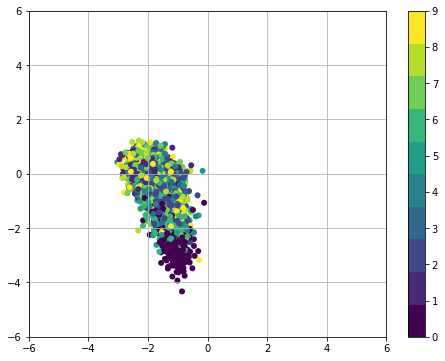

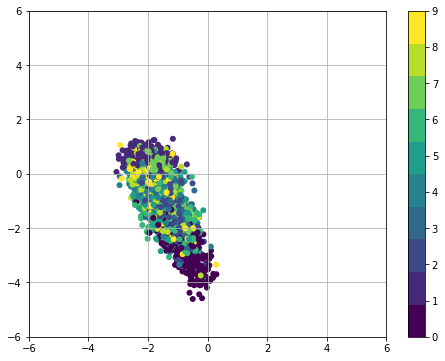

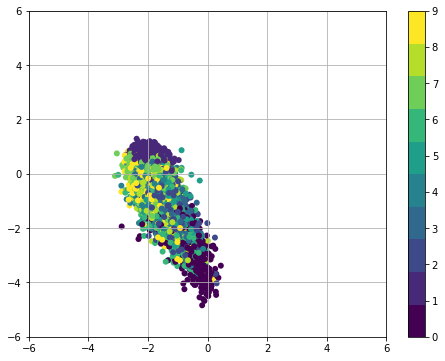

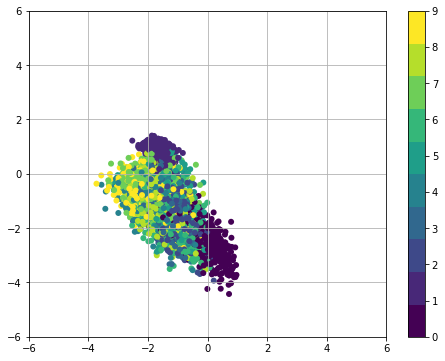

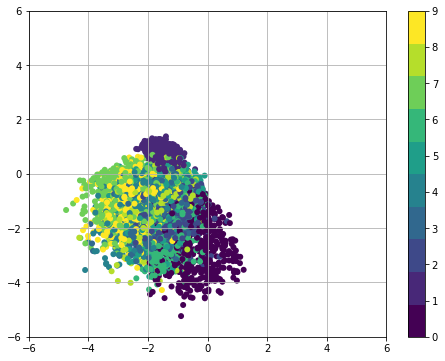

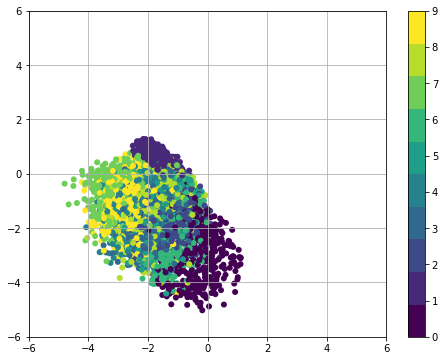

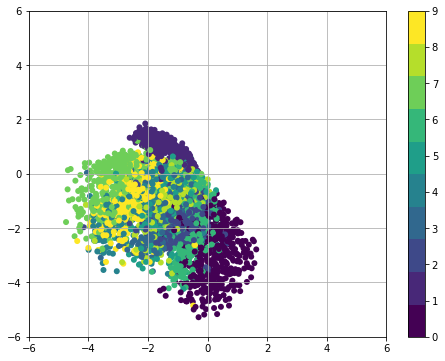

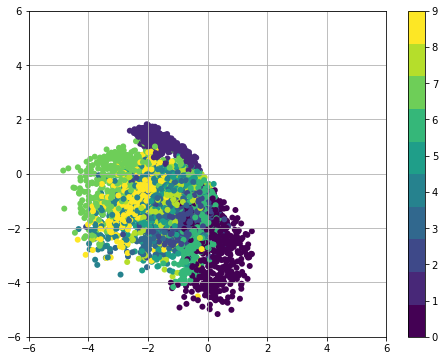

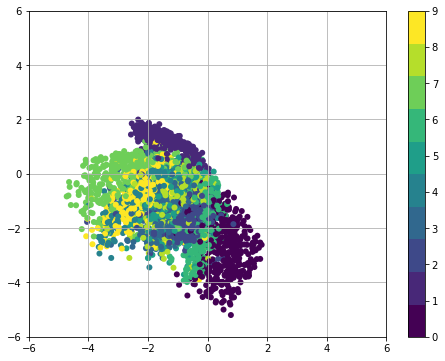

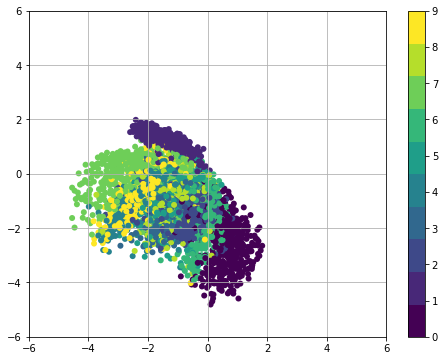

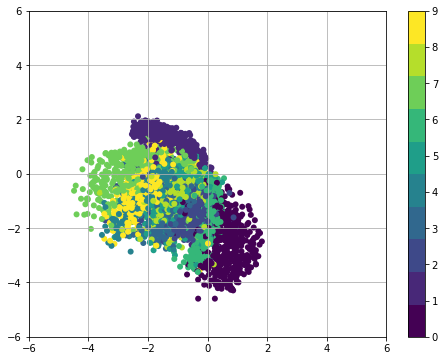

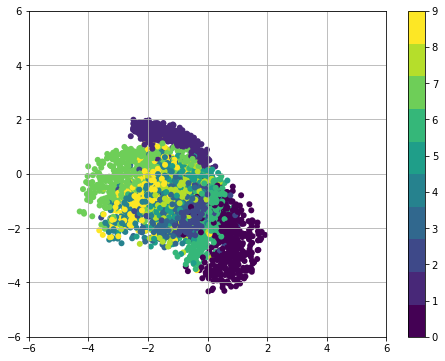

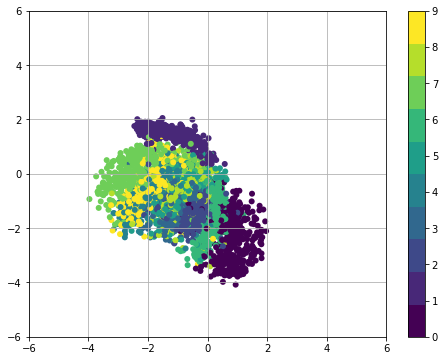

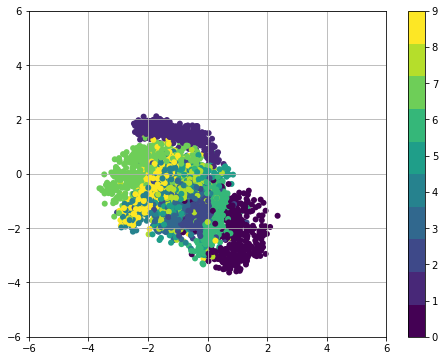

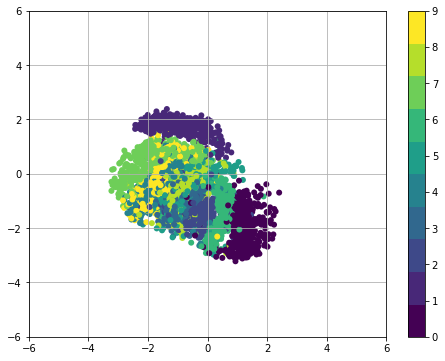

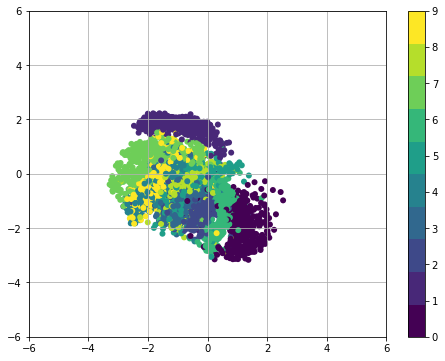

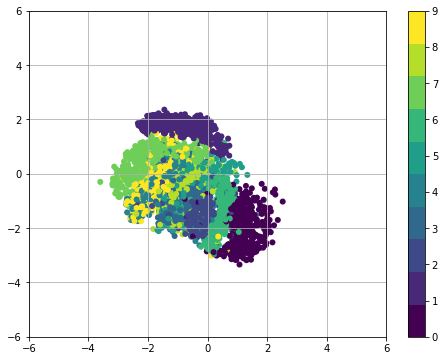

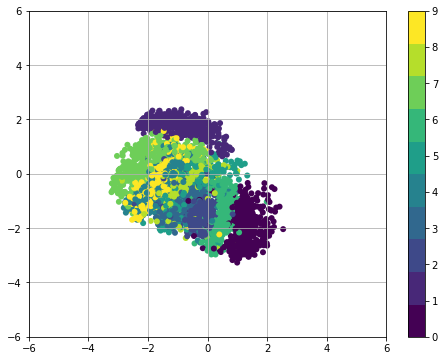

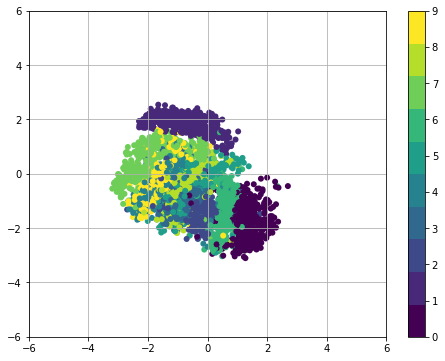

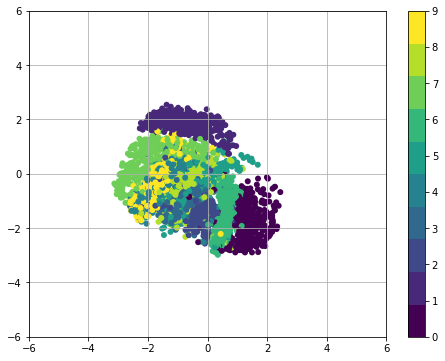

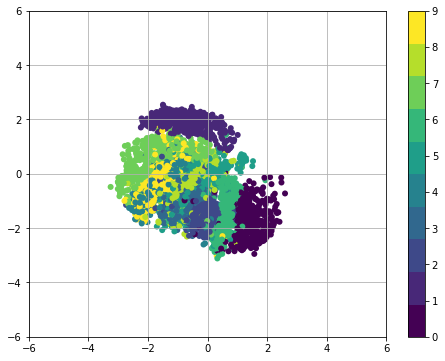

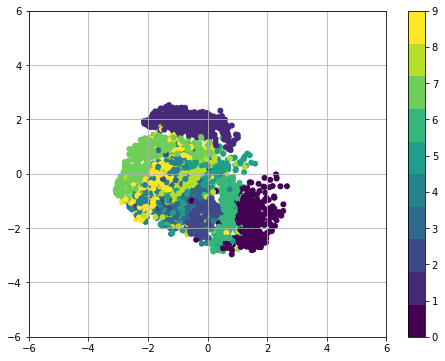

In [13]:
# Train

total_batch = int(n_sample / batch_size)
min_tot_loss = 1e99

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})
    
    for epoch in range(n_epochs):
        
        # Random Shuffling
        np.random.shuffle(train_total_data)
        train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS] #Delete the columns of target variables[1 of K coding], It is unsupervised learning.
        
        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_sample)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]            
            batch_xs_target = batch_xs_input #target variable is input image 
            
            _, tot_loss, loss_likelihood, loss_divergence = sess.run((train_op, loss, marginal_likelihood, KL_divergence), feed_dict={x_hat:batch_xs_input, x:batch_xs_target, keep_prob:0.9})
        
        # Print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))
        
        # If minimum loss is updated or final epoch, plot results
        
        if min_tot_loss > tot_loss or epoch+1 == n_epochs:
            min_tot_loss = tot_loss
            print(tot_loss)
            
            #Plot for reproduce performance
            if PRR:
                y_PRR=sess.run(y, feed_dict={x_hat:x_PRR, keep_prob:1}) #no dropout
                y_PRR_img = y_PRR.reshape(n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                #PPR.save_images(y_PPR_img, name="/PPR_epoch_%02d" %(epoch) + ".jpg")
                
                
                #PRR.save_images(x_PRR_img, name='input_noise.jpg')
                img_PRR_y = np.zeros((IMAGE_SIZE_MNIST*PRR_n_img_x, IMAGE_SIZE_MNIST*PRR_n_img_y))
                for idx, image in enumerate(y_PRR_img):
                    i = int(idx%PRR_n_img_x)
                    j = int(idx/PRR_n_img_x)
                    if idx == 0:
                        print(image.shape)
                        
                    img_PRR_y[i*IMAGE_SIZE_MNIST:i*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST, j*IMAGE_SIZE_MNIST:j*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST] = image
                
                imsave(RESULT_DIR+"/PRR_epoch_%20d"%(epoch)+".jpg", img_PRR_y)
                
                
            # Plot for manifold learning result
            if PMLR and dim_z == 2:
                z_input = np.mgrid[-4:4:PRR_n_img_x*1j, -4:4:PRR_n_img_y*1j]
                z_input = np.moveaxis(z_input, 0, -1)
                z_input = z_input.reshape([-1,2])
                y_PMLR = sess.run(latent_variable, feed_dict={z_in:z_input, keep_prob : 1})
                y_PMLR_img = y_PMLR.reshape(n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                #PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")
                
                img_PMLR = np.zeros((IMAGE_SIZE_MNIST*PRR_n_img_x, IMAGE_SIZE_MNIST*PRR_n_img_y))
                for idx, image in enumerate(y_PMLR_img):
                    i = int(idx%PRR_n_img_x)
                    j = int(idx/PRR_n_img_x)
                    if idx == 0:
                        print(image.shape)
                        
                    img_PMLR[i*IMAGE_SIZE_MNIST:i*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST, j*IMAGE_SIZE_MNIST:j*IMAGE_SIZE_MNIST+IMAGE_SIZE_MNIST] = image
                    
                imsave(RESULT_DIR+"/PMLR_epoch_%20d"%(epoch)+".jpg", img_PMLR)
                    
                
            # plot distribution of labeled images
                z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
                #PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")
                N = 10
                plt.figure(figsize=(8,6))
                base = plt.cm.get_cmap(None,10)
                plt.scatter(z_PMLR[:,0], z_PMLR[:,1], c=np.argmax(id_PMLR, 1), marker='o', edgecolor='none', cmap=base)
                plt.colorbar(ticks=range(N))
                axes = plt.gca()
                axes.set_xlim([-6,6])
                axes.set_ylim([-6,6])
                plt.grid(True)
                plt.savefig(RESULT_DIR + "/PMLR_map_epoch_%02d"%(epoch)+".jpg")